# Ephaptic Coupling
This code was used in a project about ephaptic coupling with parrallel ball and stick cells in a square grid. In this model we configure the cells for resamble the orientation of the cortical cells. 

In [1]:
#%pylab notebook
import random as rd
from neuron import h , gui
from neuron.units import ms , mV
import matplotlib.pyplot as plt
import numpy as np
import os
import math
h.load_file('stdrun.hoc')

1.0

EN - <ul>
<li><code>%pylab notebook </code> enhances graph visualization (melhor visualização de gráficos)
<li><code>"neuron"</code> import the simulation enviorment (importação do ambiente de simulação NEURON)
<li><code>"h.load_file('stdrun.hoc')"</code> is required to create simulations with NEURON (utilizado pra criar simulações mais complexas com o NEURON)
<li<code>matplotlib"</code> is the basic for graphing and plotting results (visualização de gráficos)
<li><code>"os"</code> is for selacting the folder for saving the files (selecionar as pastas para salvar os arquivos)
<li><code>"numpy"</code>, <code>"math"</code> and <code>"scipy"</code> is for complex operations and data analisys (operações complexas e analise de dados)
</ul>

PT - <ul>
<li><code>%pylab notebook </code>  melhor visualização de gráficos
<li><code>"neuron"</code> importação do ambiente de simulação NEURON
<li><code>"h.load_file('stdrun.hoc')"</code> utilizado pra criar simulações mais complexas com o NEURON
<li<code>matplotlib"</code> visualização de gráficos
<li><code>"os"</code> selecionar as pastas para salvar os arquivos
<li><code>"numpy"</code>, <code>"math"</code> and <code>"scipy"</code> operações complexas e analise de dados
</ul>

# Parâmetros 
Source (Fontes): 

1. Extracelular mechanisms from \cite{Appukutan2017}

2. Extracellular conductivity (Condutividade extracelilar) from no ELFENN \cite{Shiffman2019}

The xraxial follows the equation: $$ xraxial[0]_{sec} = \frac{4}{\sigma \pi d^2_{sec}} $$

the $g_{eph}$ follows the equation: $$ g_{eph} =  \frac{2 \sigma }{d_{sec}\ln(d_{sep}/d_{sec})(4+4\sqrt{2})} $$

Those formulations consider that the extracelular medium is represented by a cylinder with diameter $\sqrt 2 d_{sep}$ . This approach consider charges mostly flowing in the reagion near de cell segment.

PT - Esses formulações dos parametros consideram que o meio extracelular é representado por um cilindro no meio extracelular com diametro de $\sqrt 2 d_{sep}$. Essa abordagem toma em conta que as cargas vão principalmente se deslocar na região mais proxima ao segmento de célula.

In [2]:
#### Basic parametres (parametros basicos) ####

ncell = 3 #the total number of cells is ncell**2, it is a square grid with ncell lines and ncell colluns
            # (ncell linhas e ncell colunas totalizando ncell**2 celulas em uma rede quadrada)
celldist = 30 #micrometers = um #distance between cells (distancia entre as células)

# Cell size, all cell parts is a cilinder (tamanhos das celulas, todas as partes da célula são um cilindro) 
diam_soma = 20 #micrometers = um #soma diameter, soma diameter = soma lenght (diametro do soma, diametro do soma = comprimento do soma)
L_dend = 100 #micrometers = um #dendrite lenght (comprimento do dendrito)
diam_dend = 5 #micrometers = um #dendrite diameter (diametro do dendrito)

R_a = 183 #Ohm * cm #intracellular axial resistance (resistencia axial intracelular)

sigma = 0.5 #S/m #extracallular conductivity (condutividade extracelular)

#### Secondary parameters (parametros secundários) 

# parameters for constructing the NEURON's "extracellular mechanism"
r_axial_extracell = [0, 10**9] #MOhm/cm # resistivity in the axial oriention
g_extracell = [10**(-9), 10**9] #S/cm2 # verificar xg[0] # conductivity in radial orientation
c_extracell = [0, 0] #uF/cm2 # extracelular capacitance for modeling myelin sheath
e_extracell = 0 #mV # extracelular reversal potential

xraxial_soma = 4*10**(-6)/(sigma*10**(-2)*h.PI*((diam_soma*10**(-4))**2)) 
xraxail_dend = 4*10**(-6)/(sigma*10**(-2)*h.PI*((diam_dend*10**(-4))**2)) 
g_eph_soma = ( 2*sigma*(10**(-2))/(diam_soma*(10**(-4))*math.log(celldist/diam_soma)) )/( 4+4*(2**(1/2)) )
g_eph_dend = ( 2*sigma*(10**(-2))/(diam_dend*(10**(-4))*math.log(celldist/diam_dend)) )/( 4+4*(2**(1/2)) )

#### sinapse model is the double exponential. sinapses Exp2Sim - subida continua e expoencial e decaimento exponencial
syn_prob = 0.3 # values between (0,1]

syn_tau1_exc = 5 #ms
syn_tau2_exc = 10 #ms
syn_exc = 0 #mV
netcon_weight_exc = 0.02 #peso sinaptico, entra na equação da condutividade
netcon_delay_exc = 10 * ms #tempo entre o estimulo e a sinapse
netcon_threshold_exc = -20 #mV 

percentInh = 0.2 #percentage of inhibitory neurons
syn_tau1_inh = 5 #ms
syn_tau2_inh = 10 #ms
syn_inh = -70 #mV
netcon_weight_inh = 0.02 #peso sinaptico, entra na equação da condutividade
netcon_delay_inh = 10 * ms #tempo entre o estimulo e a sinapse
netcon_threshold_inh = -20 #mV 

#### estumulação
stim_interval = 120
stim_tau1 = 5 #ms
stim_tau2 = 10 #ms
stim_e = 0 #mV
stim_weight = 0.02 #peso sinaptico, entra na equação da condutividade
stim_delay = 0 * ms #tempo entre o estimulo e a sinapse
stim_threshold = -20 #mV 

#### frequencia de amostragem - sample fequency
fs = 40000 #Hz

#### simulation duration 
sim_dur = 1500 #ms
#### initial condition of intracellular electric potential
v_inicial = -68 #mV
#### number of seeds
nseeds = 1

### Cell objects

EN - The objects are from NEURON tutorial and was adapted for this project. The first object (class Cell) is for creating a cell in a point of space. The second object (class ToyCell) sets the format and biophysics for the cells. The last part of ToyCell class is the configuration of extracelullar mechanisms, the <code>if</code>'s connects the extracellular medium to the zero potential. The first one connects the corner cells to the ground, the second one connects the side cells to the ground potential. The hipothesis here is that every cell have 8 connections to each cell extracellular space, so the ones that are not connected tho the other cells are connected to the ground potential.

PT - Os objetos são retirados do tutorial NEURON e foram adaptados para esse projeto. O primeiro objeto (class Cell) cria uma célula em um ponto no espaço. O segundo objeto (class ToyCell) configura o formato e a biofísica da celula. A ultima parte do class ToyCell configuramos o extracellular mechanisms, os if's conecta os meios extracelulares para o potencial nulo, sendo o primeiro conectando as células dos cantos ao potencial terra e o segundo conectando as celulas nas laterais. A hipotese aqui é que todas as células tem 8 coneções permitidas para cada nó extracelular. Assim as células das bordas, que não fazem todas suas possibilidades de conexão com outras células, tem as conexões restantes ligadas no potencial nulo.

In [3]:

class Cell:
    def __init__(self, index, x, y, z):
        self.index = index
        self._morphology()
        self.all = self.soma.wholetree() #Can be soma.wholetree() ou dend.wholetree() (pode sumir essa linha)
        self._biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._set_position(x, y, z)
        
    def _set_position(self, x, y, z):
        for section in self.all: #selecting each section of the tree (soma, dends, axon)
            for isegment in range(section.n3d()): 
                section.pt3dchange(isegment,
                                   x + self.x + section.x3d(isegment),
                                   y + self.y, #+ section.y3d(isegment),
                                   z + self.z, #+ section.z3d(isegment),
                                   section.diam3d(isegment))
            self.x, self.y, self.z = x, y, z

class ToyCell(Cell):
    """
    EN - Creates a cell with a soma and one dendrite with one segment each. The parameters esed here are in the parameters sections of the code
    PT - Cria celula com um soma e um dendrito com um segmento cada. Os parametros usados aqui estão na celula de parametros"""
    def _morphology(self):
        self.soma = h.Section(name="soma")
        self.dend = h.Section(name="dend")
        
        self.soma.connect(self.dend)
        
        # lenght of cell parts
        self.soma.L = self.soma.diam = diam_soma #micrometers
        self.dend.L = L_dend # micrometers
        self.dend.diam = diam_dend

    def _biophysics(self):
        #active mechanisms 
        self.soma.insert('hh')
#         for segSoma in self.soma:
#             segSoma.hh.el = -60
#             segSoma.hh.gnabar = 0.2
#             segSoma.hh.gkbar = 0.001
        
        #passive mechanisms
        self.dend.insert('pas')
#             for segPassivos in passivos:
#                 segPassivos.pas.e = -70 #de que ion é esse potencial reverso
#                 segPassivos.pas.g = 0.01 # na real issos são listas

        #insert extracellular mechanhisms
        for sec in self.all:
            sec.insert('extracellular')
            for segmento in sec:
                segmento.xraxial[1] = r_axial_extracell[1] 
                segmento.xg[1] = g_extracell[1]
                segmento.xc[0] = c_extracell[0]
                segmento.xc[1] = c_extracell[1]
                segmento.extracellular.e = e_extracell                
            sec.Ra = R_a
            
        for seg_soma in self.soma:
            seg_soma.xraxial[0] = xraxial_soma
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_soma.xg[0] = (2+3*(2**(1/2)))*g_eph_soma               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_soma.xg[0] = (1+2*(2**(1/2)))*g_eph_soma
            else:
                seg_soma.xg[0] = g_extracell[0] ## não borda == infinitesimal

        for seg_dend in self.dend:
            seg_dend.xraxial[0] = xraxail_dend
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_soma.xg[0] = (2+3*(2**(1/2)))*g_eph_dend               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_soma.xg[0] = (1+2*(2**(1/2)))*g_eph_dend
            else:
                seg_dend.xg[0] = g_extracell[0] ## não borda == infinitesimal

# Funções do programa

In [4]:
def create_InhNeurons(cells):
    """ EN - In this functions it will be selected which neurons would be inhibitory. It will be used 
    the proportion of 20% inhibitory for 80% exitatory.
    PT - nessa função vamos definir que neuronios serão inibitorios. Para isso utilizaremos a proporção
    de 20% inibitórios para 80% excitatorios"""
    inh_cell = []
    ntotalcell = ncell**2
    # len(inh_cell) <= ntotalcell*0.2
    while len(inh_cell) < ntotalcell*percentInh:
        rd_line = rd.choice(cells)
        rd_neuron = rd.choice(rd_line)
        if not(rd_neuron in inh_cell): 
            inh_cell.append(rd_neuron)
    return inh_cell  

def syn_connection(celulas, inh_cell): 
    """
    EN - Given a matrix of cells, it conects all cells that are first neighbours from each other. 
    It has been used duble exponential synapse. Connection will be done if, given a cell[i][j] and cell[m][n]
    i - m <= 1 & j - n <= 1, connecting neighbours in the diagonal, vertical and horizontal. 
    The probability of a synapse to be done is determined by syn_prob.
    PT - Dada uma lista de celulas queremos fazer uma conexão sinaptica entre a celula proximas.
    Utilizaremos sinapses exponencias duplas. A conexão acontece se a celula for a primeira vizinha de outra
    Assim i - m <= 1 & j - n <= 1, temos que conectaremos as vizinhas nas diagonais e na vertical e horizontal.
    A probabilidade de uma sinapse ser feita é indicada pela variavel syn_prob.
    """
    netcons, syns, target = [], [], []
    for (i, linCel1) in enumerate(celulas):
        for (j, sourceCell) in enumerate(linCel1):
            for (m, linCel2) in enumerate(celulas):
                for (n, targetCell) in enumerate(linCel2):
                    if sourceCell.index != targetCell.index and abs(i - m) <= 1 and abs(j - n) <= 1:  
                        trgt = celulas[m][n] #I do this beacuse NEURON have some bugs
                        syn = h.Exp2Syn(trgt.dend(1))
                        nc = h.NetCon(celulas[i][j].soma(0)._ref_v, syn, sec = celulas[i][j].soma) 
                        if (sourceCell in inh_cell) and not(targetCell in inh_cell): #inh>>exc
                            nc.weight[0] = netcon_weight_inh
                            syn.tau1 = syn_tau1_inh
                            syn.tau2 = syn_tau2_inh
                            syn.e = syn_inh
                            nc.delay = netcon_delay_inh #ms
                            nc.threshold = netcon_threshold_inh #mV
                        elif not(sourceCell in inh_cell) and not(targetCell in inh_cell): #exc>>exc
                            nc.weight[0] = netcon_weight_exc 
                            syn.tau1 = syn_tau1_exc
                            syn.tau2 = syn_tau2_exc
                            syn.e = syn_exc
                            nc.delay = netcon_delay_exc #ms
                            nc.threshold = netcon_threshold_exc #mV
                        elif not(sourceCell in inh_cell) and (targetCell in inh_cell): #exc>>inh 
                            nc.weight[0] = netcon_weight_exc 
                            syn.tau1 = syn_tau1_exc
                            syn.tau2 = syn_tau2_exc
                            syn.e = syn_exc
                            nc.delay = netcon_delay_exc #ms
                            nc.threshold = netcon_threshold_exc #mV
                        else: #inh>>inh There is no connection
                            nc.weight[0] = 0
                        netcons.append(nc)
                        syns.append(syn) 
                        trgt.x = trgt.soma.L + trgt.dend.L
                        target.append(trgt)
    total_syns = len(syns)*syn_prob
    while len(syns) > total_syns:
        indexx = rd.randint(0,len(syns)-1)
        exclude_target = target[:]
        del exclude_target[indexx]
        if target[indexx] in exclude_target:
            del target[indexx]            
            del syns[indexx]  
            del netcons[indexx]
        #### I do this because there is certanty in the numbre of synapses beeing done.
    return netcons, syns, target #target in here is used to calculate LFP in the LFP class

def criar_celulas(N):
    """EN - Creates N^2 cells in a square mesh. all cells are positioned in the xy plane
    PT- cria N^2 celulas numa malha quadrada. As celulas estão posicionadas no plano xy"""
    cellmatrix = []
    cellline = []
    for i in range(N):
        for j in range(N):
            cellline.append(ToyCell({'i':i ,'j':j},0, i * celldist, j * celldist))
        cellmatrix.append(cellline)
        cellline = []
    return cellmatrix

def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0, 
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())

def testeDoOffsetSendoNseg(nseg, ncell, i, col, lin):
    """Testa se o valor da casela da matriz tem que ser zero
    para o offset == nseg e para offset == ncell*nseg+nseg"""
    for lin in lin:
        if i == nseg* (col+lin + (ncell-1)*lin) or i == nseg* (col+lin + (ncell-1)*lin) + 1:
            return True 
    return False
        
def testeDoOffsetDoNegativo(nseg, ncell, i, lin):
    """Testa se o valor da casela da matriz tem que ser zero
    para o offset == ncell*nseg-nseg"""
    for lin in lin:
        if i == nseg* ncell*lin or i == nseg* ncell *lin + 1:
            return True 
    return False

def extracellular_link(celulas, qtdcell):
    """
    EN - Creates a single linear mechanism to the network, ceating the continous extracellular espace for ncell>2
    Works properly only for cells with 2 sections and one segment for each section.
    PT - Cria um unico linear mech pra todo o tecido, criando o meio extracelular continuo para o ncell>2
    Funciona bem para celulas com 2 seçoes e nseg == 1 em cada uma delas
    """
    nseg = 0
    for sec in celulas[0][0].all:
        nseg += sec.nseg
    g_e_soma = g_eph_soma
    g_e_dend = g_eph_dend
    
    tam = nseg * (qtdcell**2)  #tamanho dos vetores
    c = h.Matrix(tam, tam) #(nroll,ncoll)
    g = h.Matrix(tam, tam)
    y = h.Vector(tam) #(lengnth) esse aqui diz sobre uma corrente externa aplicada
    b = h.Vector(tam)
    sl = h.SectionList()
    xvec = h.Vector(tam)
    layervec = h.Vector(tam)
                
    condutancias = np.zeros((tam,tam))
    col = np.arange(ncell)
    lin = np.arange(ncell)
    for offset in range(tam): #percorre as diagonais
        if offset == nseg: #testa pra ver se é uma diagonal que vai se != 0 para o valor de nsegtotal da célula
            for i in range(tam-offset): #pega o restante das colunas que falta dado o offset
                if testeDoOffsetSendoNseg(nseg, ncell, i, col[(ncell-1)], lin[:(ncell-1)]):
                    condutancias[i][i+offset] = 0
                else:
                    if i%2 != 0: #linha referente ao soma
                        condutancias[i][i+offset] = -g_e_soma
                    else: #linha referente ao dend
                        condutancias[i][i+offset] = -g_e_dend
        elif offset == (qtdcell * nseg) - nseg:
            for i in range(tam-offset):
                if testeDoOffsetDoNegativo(nseg, ncell, i, lin):
                    condutancias[i][i+offset] = 0
                else:
                    if i%2 != 0: 
                        condutancias[i][i+offset] = -g_e_soma/math.sqrt(2)
                    else: 
                        condutancias[i][i+offset] = -g_e_dend/math.sqrt(2)
        elif offset == qtdcell * nseg:
            for i in range(tam-offset):
                if i%2 != 0: 
                    condutancias[i][i+offset] = -g_e_soma
                else: 
                    condutancias[i][i+offset] = -g_e_dend
        elif offset == (qtdcell * nseg) + nseg :   
            for i in range(tam-offset):
                if testeDoOffsetSendoNseg(nseg, ncell, i, col[(ncell-1)], lin[:(ncell-1)]):
                    condutancias[i][i+offset] = 0
                else:
                    if i%2 != 0:
                        condutancias[i][i+offset] = -g_e_soma/math.sqrt(2)
                    else: 
                        condutancias[i][i+offset] = -g_e_dend/math.sqrt(2)
    condutancias = symmetrize(condutancias) #simetrize the matrix
    for i in range(tam): #buids up the matriz diagonal summing the condoctances of the line
        condutancias[i][i] = (-1)*np.sum(condutancias[i])
    for (indiceLinha, linha) in enumerate(condutancias): #transforma matriz do numpy para o hoc
        for (indiceCol, item) in enumerate(linha):
            g.setval(indiceLinha,indiceCol,item)
    
    #for k in range(neg):  dai n muda tb o que ta escrito embaixo, caso trabalhemos com celulas com >1 seg
    for i in range(ncell):
        for j in range(ncell):
            for sec in celulas[i][j].all:
                sl.append(sec)
    for i in range(tam):
        xvec[i] = 0.50

    #seting to get the first layer of the extracellular medium. Zero would be the intracellular potential
    layervec.fill(1)
    
    return  c, g, y, b, sl, xvec, layervec

def random_stimulation():
    """ EN- allocates one random stimulation at each neuron of the network. 
    HYPOTHESIS: all neurons are reciving aleatory spikes from other cortex cells 
    PT- coloca uma(1) estimulação com entrada aleatoria em cada neuronio da rede
    HIPOTESE: todos os neuronios estão sofrendo spikes de outras celulas do cortex."""
    stimulators = []
    syns_ = []
    ncstims = []
    for (i, linhaCel) in enumerate(celulas):
        for (j, ____) in enumerate(linhaCel):
            stimulator = h.NetStim() # Make a new stimulator            
            stimulator.number = 100000 #number of spikes
            stimulator.start = stim_interval*np.random.rand()* ms #NetStim will start at t=0
            stimulator.interval = stim_interval*np.random.rand()* ms
            stimulator.noise = 1 # 1 -> poisson spikes
            syn_ = h.Exp2Syn(celulas[i][j].dend(1)) #synapse with continous conductance
            syn_.tau1 = stim_tau1 #ms
            syn_.tau2 = stim_tau2 #ms
            syn_.e = stim_e
            ncstim = h.NetCon(stimulator, syn_)
            ncstim.delay = stim_delay *np.random.rand()#ms
            ncstim.weight[0] = stim_weight
            ncstim.threshold = stim_threshold #mV
            
            stimulators.append(stimulator)
            syns_.append(syn_)
            ncstims.append(ncstim)
    return stimulators, syns_, ncstims

# Simuation setup

In [5]:
celulas = criar_celulas(ncell)   # cerate cells        

# h.PlotShape(False).plot(plt)
# plt.xlabel('x')
# plt.ylabel('z')



#configura o acoplamento efatico - sets the ephaptic coupling
c, g, y, b, sl, xvec, layervec = extracellular_link(celulas, ncell)
conection = h.LinearMechanism(c, g, y, b, sl, xvec, layervec)

# Attach it to a synapse in the end of the dendrite of the first cell in the network. 
#(Named 'syn_' to avoid being overwritten with the 'syn' variable assigned later.)
stimulators, syns_, ncstims =  random_stimulation()

h.dt = 1/(fs/1000) #0.025 ms => 40 steps per ms

# Data aquisition

EN - in this part of the code we create a first the hoc vector for recording the data and use th buit in fuctions os NEURON. After running the simulation we transform the hoc vectors in numpy arrays to easily export the data with the <code>.tofile</code> function.

PT - nessa parte do codigo primeiro criamos os vetores em hoc para fazer a simulação e guardar os resultados com funções proprias do NEURON. Depois de rodar as simulações transformamos essa estrutura em um numpy array para mais facilmente exportar os dados utilizando a função <code>.tofile</code>.

In [6]:
def record_spikes(celulas):
    spikes = h.List()
    for linha_cell in celulas:
        for cell in linha_cell:
            vec = h.Vector()
            netcon = h.NetCon(cell.soma(0.5)._ref_v, None, sec=cell.soma)  
            netcon.record(vec)  # vec will record the firing times
            spikes.append(vec)  # add vec to the list of vectors that record firing times
    return spikes

for l in range(nseeds):
    inh_cell = create_InhNeurons(celulas)
    conexao, sinapse, alvo = syn_connection(celulas, inh_cell)
    
    spikes = record_spikes(celulas)

    time = h.Vector().record(h._ref_t)

    record_intra = [h.Vector(), h.Vector(), h.Vector()]
    record_intra[0].record(celulas[0][0].soma(0.5)._ref_v)
    record_intra[1].record(celulas[1][1].soma(0.5)._ref_v)
    record_intra[2].record(celulas[2][2].soma(0.5)._ref_v)

    record_extra = []
    corr_mem_soma = [] # units of mA/cm2
    corr_mem_dend = [] # units of mA/cm2
    for m in range(ncell):
        record_extra.append([])
        corr_mem_soma.append([])
        corr_mem_dend.append([])
        for n in range(ncell):
            record_extra[m].append(h.Vector())
            record_extra[m][n].record(celulas[m][n].soma(0.5)._ref_vext[0])
            corr_mem_soma[m].append(h.Vector())
            corr_mem_soma[m][n].record(celulas[m][n].soma(0.5)._ref_i_membrane)
            corr_mem_dend[m].append(h.Vector())
            corr_mem_dend[m][n].record(celulas[m][n].dend(0.5)._ref_i_membrane)

    corr_syn = [] # units of nA
    for m, syn in enumerate(sinapse):
        corr_syn.append(h.Vector())
        corr_syn[m].record(syn._ref_i)

    h.finitialize(v_inicial * mV) #initialize and set the starting point of the simulation
    h.continuerun(sim_dur * ms)

        
    # transform hoc Vector() in np.array(), because its easier to export the np.array data
    time = np.array(time)
    
    spikes = np.array(spikes)
    for i, _ in enumerate(spikes):
        spikes[i] = np.array(spikes[i])
    
    for i, _ in enumerate(record_intra):
        record_intra[i] = np.array(record_intra[i])
    record_intra = np.array(record_intra)

    for m in range(ncell):
        for n in range(ncell):
            record_extra[m][n] = np.array(record_extra[m][n])
            corr_mem_soma[m][n] = np.array(corr_mem_soma[m][n])
            corr_mem_dend[m][n] = np.array(corr_mem_dend[m][n])
        record_extra[m] = np.array(record_extra[m])
        corr_mem_soma[m] = np.array(corr_mem_soma[m])
        corr_mem_dend[m] = np.array(corr_mem_dend[m])
    record_extra = np.array(record_extra)
    corr_mem_soma = np.array(corr_mem_soma)
    corr_mem_dend = np.array(corr_mem_dend)

    for i, _ in enumerate(corr_syn):
        corr_syn[i] = np.array(corr_syn[i])
    corr_syn = np.array(corr_syn)

C:\Users\angel\AppData\Local\Temp/ipykernel_11936/2759852658.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikes = np.array(spikes)


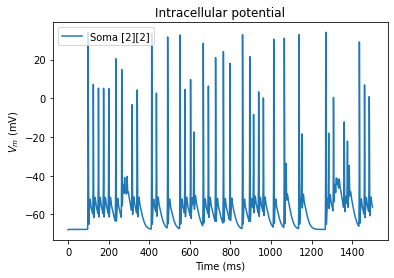

In [7]:
plt.figure()
plt.plot(time, record_intra[2], label='Soma [2][2]')
plt.ylabel('$V_m$ (mV)')
plt.xlabel('Time (ms)')
plt.title('Intracellular potential')
plt.legend()
plt.show()

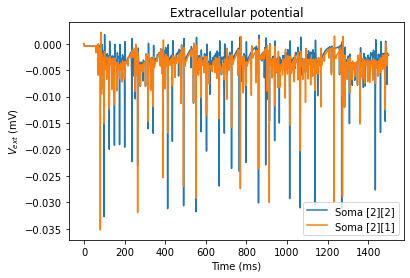

In [9]:
plt.figure()

plt.plot(time,record_extra[2][2], label='Soma [2][2]')
plt.plot(time,record_extra[2][0], label='Soma [2][1]')

plt.title('Extracellular potential')
plt.ylabel('$V_{ext}$ (mV)')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

# testes